# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Keras / Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '21'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="graupel"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                     (cell: 2684736)
Dimensions without coordinates: cell
Data variables: (12/145)
    time                        (cell) float32 ...
    q_cloud                     (cell) float32 ...
    n_cloud                     (cell) float32 ...
    q_rain                      (cell) float32 ...
    n_rain                      (cell) float32 ...
    q_ice                       (cell) float32 ...
    ...                          ...
    frze_graupel_rain_mass      (cell) float32 ...
    frze_graupel_rain_rmass     (cell) float32 ...
    frze_graupel_rain_rvol      (cell) float32 ...
    frze_graupel_rain_liq       (cell) float32 ...
    rime_graupel_rain_num       (cell) float32 ...
    rime_graupel_rain_mass      (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Di 31 Mai 2022 08:35:12 CEST
    nfiles:   18051


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    ssi  = xr.open_dataset(fname).ssi.values
    q_s  = xr.open_dataset(fname).q_graupel.values
    num_s  = xr.open_dataset(fname).n_graupel.values
    rime_s = xr.open_dataset(fname).rime_graupel.values
    rvol_s = xr.open_dataset(fname).rvol_graupel.values
    liq_s  = xr.open_dataset(fname).liq_graupel.values
    # process rates
    depo_mass = xr.open_dataset(fname).depo_graupel_mass.values   
    # normalize with ssi
    depo_mass = np.where(ssi>1e-4,depo_mass/ssi,np.nan)
    # values of ssi above 1e-2 are mixed-phase and at water saturation
    depo_mass = np.where(ssi<1e-2,depo_mass,np.nan)
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # remove melting zone
    depo_mass = np.where(liq_s>q_min,np.nan,depo_mass)      
    # transform everything in log space
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*q_s)
    num_s  = np.log(num_s, where=num_s>n_min, out=np.nan*q_s)
    rime_s = np.log(rime_s, where=rime_s>q_min, out=np.nan*q_s)
    rvol_s = np.log(rvol_s, where=rvol_s>q_min, out=np.nan*q_s)
    depo_mass = np.log(depo_mass, where=depo_mass>p_min, out=np.nan*depo_mass)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, num_s, rime_s, rvol_s, temp, ssi, rho, depo_mass ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'num_s', 'rime_s', 'rvol_s', 'temp', 'ssi', 'rho', 'depo_mass' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s          num_s         rime_s         rvol_s  \
count  674161.000000  674161.000000  674161.000000  674161.000000   
mean       -8.038000       6.086931      -8.044363     -14.718854   
std         2.737113       3.020517       2.745485       2.656265   
min       -23.016296     -14.357827     -23.060617     -29.843765   
25%        -9.054448       5.088768      -9.057447     -15.830363   
50%        -7.628808       6.646637      -7.629940     -14.401778   
75%        -6.564378       8.103615      -6.566011     -13.347697   
max        -3.508092      11.288919      -3.511403      -8.822429   

                temp            ssi            rho      depo_mass  
count  674161.000000  674161.000000  674161.000000  674161.000000  
mean      254.469177       0.003179       0.830068     -15.100683  
std        11.306809       0.001151       0.159563       2.150768  
min       220.809998       0.000200       0.488000     -33.322258  
25%       247.160004       0.002500       0.721000     -15.289824  
50%       254.179993       0.002900       0.809000     -14.530664  
75%       264.000000       0.003600       0.955000     -14.032806  
max       273.140015       0.009900       1.283000      -6.105401

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s     num_s     rime_s     rvol_s        temp     ssi    rho  \
84  -13.855510  1.628024 -13.897806 -19.975204  272.679993  0.0045  1.139   
88  -13.692674  1.847478 -13.735406 -19.788427  273.040009  0.0011  1.146   
89  -13.692585  1.847478 -13.735314 -19.788349  273.059998  0.0009  1.146   
90  -13.692585  1.847478 -13.735314 -19.788349  273.079987  0.0006  1.146   
189 -11.827513  3.188417 -11.863306 -17.934189  265.160004  0.0062  0.961   

     depo_mass  
84  -19.732973  
88  -18.944624  
89  -19.013823  
90  -19.209150  
189 -17.447912

In [11]:
dataset_train.describe()

q_s          num_s         rime_s         rvol_s  \
count  472248.000000  472248.000000  472248.000000  472248.000000   
mean       -8.035664       6.089960      -8.042008     -14.716882   
std         2.734474       3.020577       2.742824       2.654723   
min       -23.016296     -14.357827     -23.060617     -29.843765   
25%        -9.051288       5.090847      -9.054448     -15.826322   
50%        -7.628366       6.649405      -7.629549     -14.401365   
75%        -6.566154       8.105308      -6.567362     -13.348135   
max        -3.509395      11.288919      -3.511403      -8.822429   

                temp            ssi            rho      depo_mass  
count  472248.000000  472248.000000  472248.000000  472248.000000  
mean      254.469574       0.003180       0.830059     -15.098151  
std        11.306872       0.001151       0.159527       2.149390  
min       220.880005       0.000200       0.488000     -33.322258  
25%       247.160004       0.002500       0.721000     -15.286123  
50%       254.160004       0.002900       0.809000     -14.530123  
75%       264.010010       0.003600       0.955000     -14.032264  
max       273.140015       0.009900       1.283000      -6.105401

In [12]:
dataset_test.describe()

q_s          num_s         rime_s         rvol_s  \
count  100776.000000  100776.000000  100776.000000  100776.000000   
mean       -8.042334       6.084055      -8.048698     -14.722662   
std         2.740705       3.017883       2.749085       2.658436   
min       -22.959501     -13.399963     -22.978586     -29.458303   
25%        -9.063689       5.086392      -9.066435     -15.839252   
50%        -7.629426       6.643236      -7.630609     -14.402641   
75%        -6.563581       8.106997      -6.565638     -13.346695   
max        -3.508092      11.248165      -3.511403      -8.822767   

                temp            ssi            rho      depo_mass  
count  100776.000000  100776.000000  100776.000000  100776.000000  
mean      254.470337       0.003175       0.830265     -15.104288  
std        11.321138       0.001152       0.159881       2.148102  
min       220.809998       0.000200       0.488000     -32.740894  
25%       247.149994       0.002500       0.721000     -15.296733  
50%       254.220001       0.002900       0.809000     -14.531818  
75%       264.019989       0.003600       0.955000     -14.034201  
max       273.140015       0.009900       1.282000      -6.558618

In [13]:
dataset_val.describe()

q_s          num_s         rime_s         rvol_s  \
count  101137.000000  101137.000000  101137.000000  101137.000000   
mean       -8.044603       6.075659      -8.051039     -14.724260   
std         2.745845       3.022862       2.754313       2.661307   
min       -23.016296     -14.357827     -23.060608     -29.482084   
25%        -9.060284       5.081715      -9.062956     -15.836456   
50%        -7.629981       6.638162      -7.630970     -14.402893   
75%        -6.559284       8.091321      -6.559778     -13.345944   
max        -3.509395      11.249871      -3.511403      -8.829305   

                temp            ssi            rho      depo_mass  
count  101137.000000  101137.000000  101137.000000  101137.000000  
mean      254.466232       0.003177       0.829917     -15.108922  
std        11.292327       0.001152       0.159419       2.159828  
min       221.520004       0.000200       0.488000     -31.911320  
25%       247.190002       0.002500       0.721000     -15.298975  
50%       254.199997       0.002900       0.809000     -14.532052  
75%       263.940002       0.003600       0.954000     -14.033809  
max       273.140015       0.009900       1.283000      -6.231778

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s          num_s         rime_s         rvol_s  \
count  464361.000000  464361.000000  464361.000000  464361.000000   
mean       -7.982048       6.134761      -7.988236     -14.664433   
std         2.640286       2.925417       2.648485       2.563943   
min       -19.999880     -14.357827     -20.046553     -26.848902   
25%        -9.021374       5.111385      -9.025938     -15.801753   
50%        -7.608410       6.654307      -7.609439     -14.387361   
75%        -6.554707       8.109526      -6.556676     -13.334938   
max        -3.509395      11.288919      -3.511403      -8.822429   

                temp            ssi            rho      depo_mass  
count  464361.000000  464361.000000  464361.000000  464361.000000  
mean      254.174789       0.003179       0.825670     -15.067184  
std        11.163411       0.001144       0.156989       2.044340  
min       220.880005       0.001400       0.488000     -28.386213  
25%       247.029999       0.002500       0.720000     -15.276634  
50%       253.919998       0.002900       0.805000     -14.534101  
75%       263.510010       0.003600       0.947000     -14.042659  
max       273.000000       0.009900       1.281000      -6.105401

In [17]:
dataset_test.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  99118.000000  99118.000000  99118.000000  99118.000000  99118.000000   
mean      -7.989598      6.125411     -7.995805    -14.671509    254.180878   
std        2.651103      2.934575      2.659342      2.573758     11.180469   
min      -19.998861    -12.483699    -20.039059    -26.813093    220.809998   
25%       -9.036618      5.104490     -9.038722    -15.814423    247.009995   
50%       -7.608058      6.647429     -7.609489    -14.388087    253.970001   
75%       -6.550938      8.111103     -6.552619    -13.333455    263.549988   
max       -3.508092     11.248165     -3.511403     -8.822767    273.000000   

                ssi           rho     depo_mass  
count  99118.000000  99118.000000  99118.000000  
mean       0.003175      0.825947    -15.075068  
std        0.001145      0.157372      2.052105  
min        0.001400      0.488000    -32.740894  
25%        0.002500      0.720000    -15.286309  
50%        0.002900      0.806000    -14.535472  
75%        0.003600      0.947000    -14.044097  
max        0.009900      1.271000     -6.558618

### Pairplot

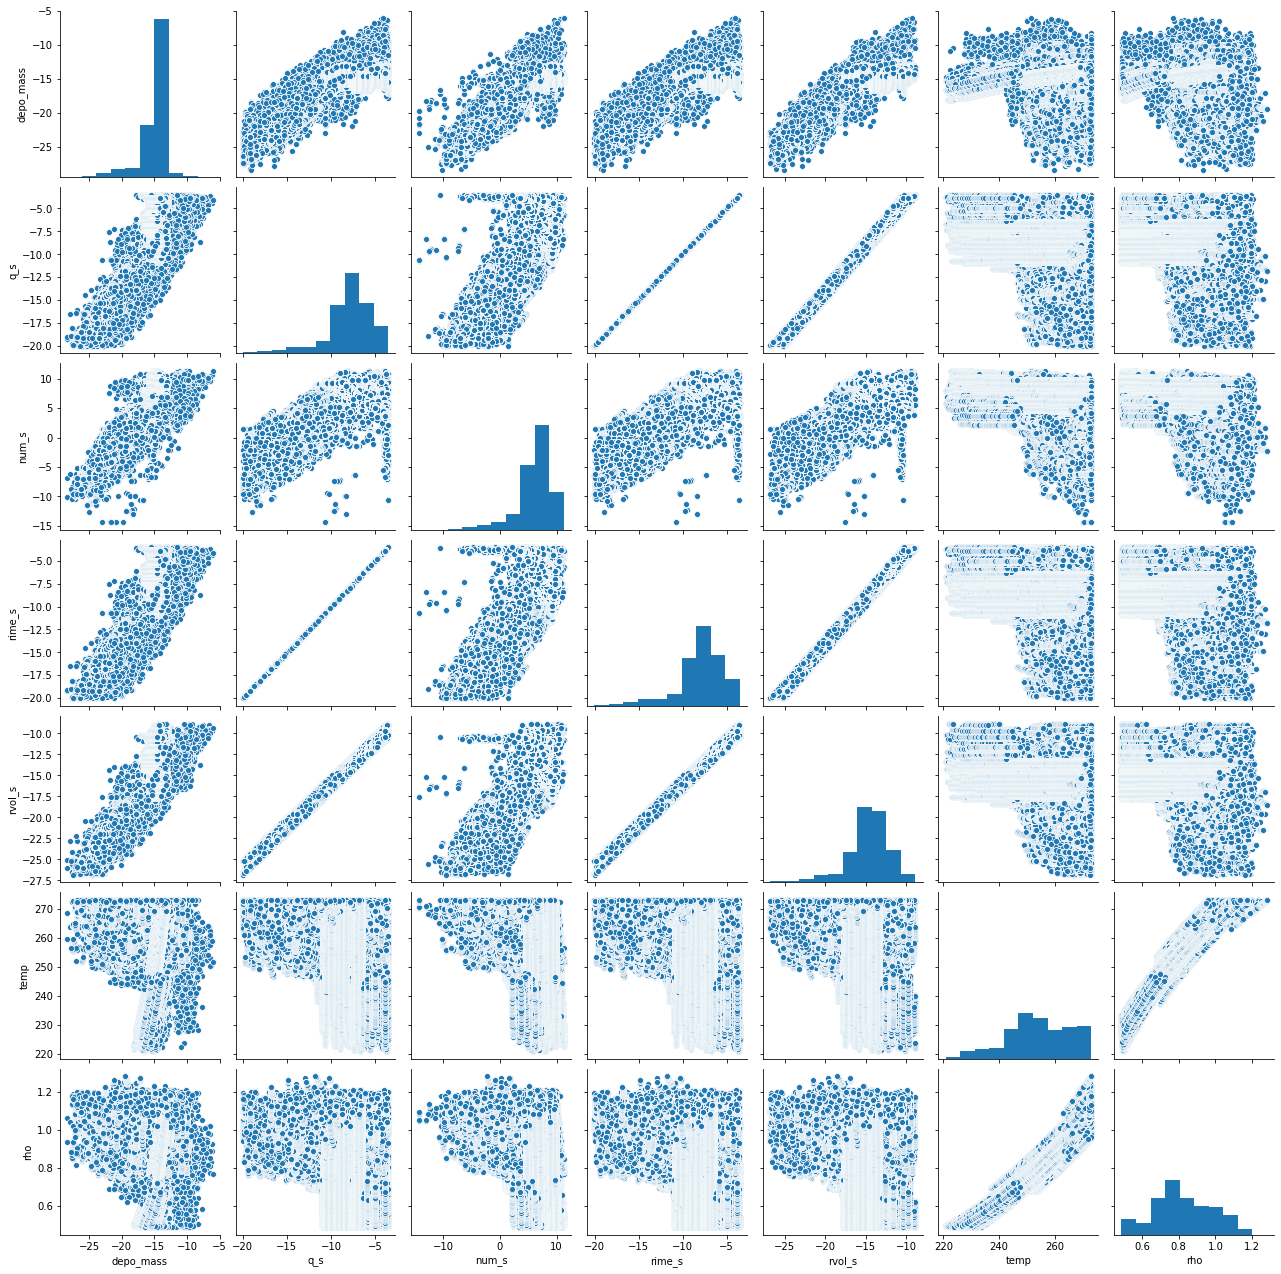

In [18]:
sns.pairplot(dataset_train[["depo_mass","q_s","num_s","rime_s","rvol_s","temp","rho"]], diag_kind="hist")

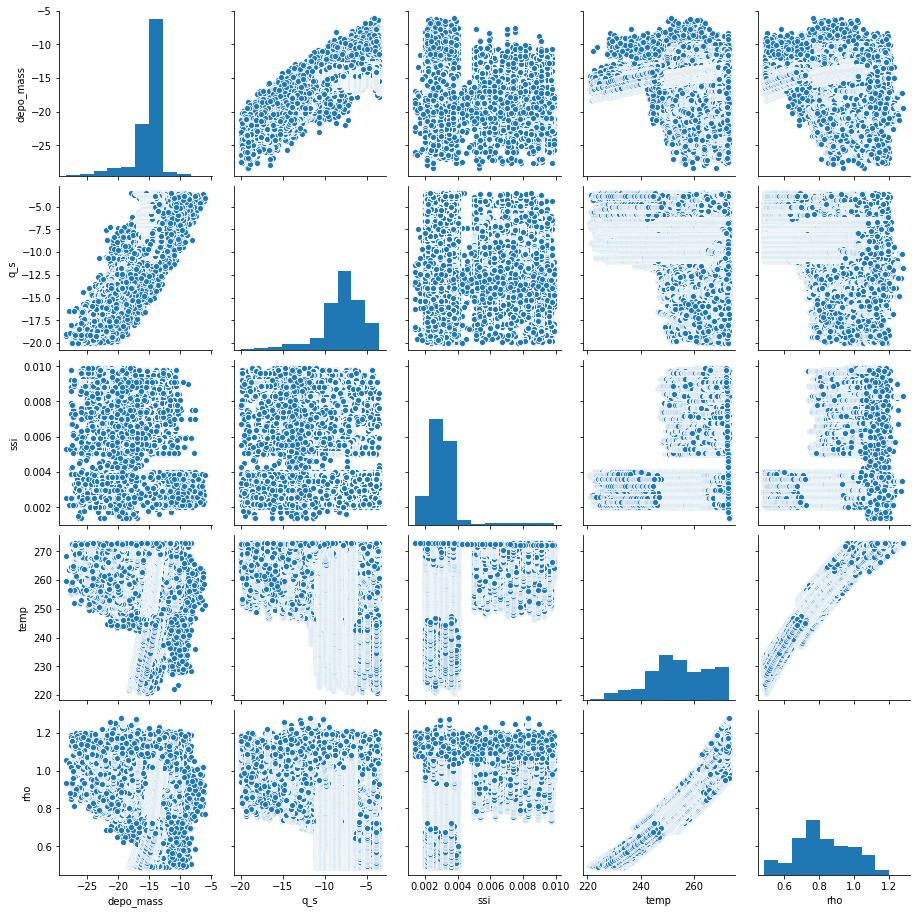

In [19]:
sns.pairplot(dataset_train[["depo_mass","q_s","ssi","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [20]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [21]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [22]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [23]:
train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
train_dataset2 = train_dataset2.drop(['ssi'], axis=1)
train_dataset3 = train_dataset3.drop(['ssi'], axis=1)

In [24]:
test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
test_dataset2 = test_dataset2.drop(['ssi'], axis=1)
test_dataset3 = test_dataset3.drop(['ssi'], axis=1)

In [25]:
val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
val_dataset2 = val_dataset2.drop(['ssi'], axis=1)
val_dataset3 = val_dataset3.drop(['ssi'], axis=1)

In [26]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("depo_mass")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s     464361.0  -7.982048  2.640286 -19.999880  -9.021374  -7.608410   
num_s   464361.0   6.134761  2.925417 -14.357827   5.111385   6.654307   
rime_s  464361.0  -7.988236  2.648485 -20.046553  -9.025938  -7.609439   
rvol_s  464361.0 -14.664433  2.563943 -26.848902 -15.801753 -14.387361   

              75%        max  
q_s     -6.554707  -3.509395  
num_s    8.109526  11.288919  
rime_s  -6.556676  -3.511403  
rvol_s -13.334938  -8.822429

In [27]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("depo_mass")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean        std         min         25%         50%  \
q_s     464361.0   -7.982048   2.640286  -19.999880   -9.021374   -7.608410   
num_s   464361.0    6.134761   2.925417  -14.357827    5.111385    6.654307   
rime_s  464361.0   -7.988236   2.648485  -20.046553   -9.025938   -7.609439   
rvol_s  464361.0  -14.664433   2.563943  -26.848902  -15.801753  -14.387361   
temp    464361.0  254.174789  11.163411  220.880005  247.029999  253.919998   
rho     464361.0    0.825670   0.156989    0.488000    0.720000    0.805000   

               75%         max  
q_s      -6.554707   -3.509395  
num_s     8.109526   11.288919  
rime_s   -6.556676   -3.511403  
rvol_s  -13.334938   -8.822429  
temp    263.510010  273.000000  
rho       0.947000    1.281000

In [28]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("depo_mass")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
q_s     464361.0   -7.982048   2.640286  -19.999880   -9.021374   -7.608410   
num_s   464361.0    6.134761   2.925417  -14.357827    5.111385    6.654307   
rime_s  464361.0   -7.988236   2.648485  -20.046553   -9.025938   -7.609439   
rvol_s  464361.0  -14.664433   2.563943  -26.848902  -15.801753  -14.387361   
temp    464361.0  254.174789  11.163411  220.880005  247.029999  253.919998   
rho     464361.0    0.825670   0.156989    0.488000    0.720000    0.805000   

               75%         max  
q_s      -6.554707   -3.509395  
num_s     8.109526   11.288919  
rime_s   -6.556676   -3.511403  
rvol_s  -13.334938   -8.822429  
temp    263.510010  273.000000  
rho       0.947000    1.281000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [29]:
# pop does not work for multiple columns, use copy instead

labels = ['depo_mass']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [31]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [32]:
train_labels.describe()

depo_mass
count  464361.000000
mean      -15.067184
std         2.044340
min       -28.386213
25%       -15.276634
50%       -14.534101
75%       -14.042659
max        -6.105401

In [33]:
train_dataset1.describe()

q_s          num_s         rime_s         rvol_s
count  464361.000000  464361.000000  464361.000000  464361.000000
mean       -7.982048       6.134761      -7.988236     -14.664433
std         2.640286       2.925417       2.648485       2.563943
min       -19.999880     -14.357827     -20.046553     -26.848902
25%        -9.021374       5.111385      -9.025938     -15.801753
50%        -7.608410       6.654307      -7.609439     -14.387361
75%        -6.554707       8.109526      -6.556676     -13.334938
max        -3.509395      11.288919      -3.511403      -8.822429

In [34]:
train_dataset2.describe()

q_s          num_s         rime_s         rvol_s  \
count  464361.000000  464361.000000  464361.000000  464361.000000   
mean       -7.982048       6.134761      -7.988236     -14.664433   
std         2.640286       2.925417       2.648485       2.563943   
min       -19.999880     -14.357827     -20.046553     -26.848902   
25%        -9.021374       5.111385      -9.025938     -15.801753   
50%        -7.608410       6.654307      -7.609439     -14.387361   
75%        -6.554707       8.109526      -6.556676     -13.334938   
max        -3.509395      11.288919      -3.511403      -8.822429   

                temp            rho  
count  464361.000000  464361.000000  
mean      254.174789       0.825670  
std        11.163411       0.156989  
min       220.880005       0.488000  
25%       247.029999       0.720000  
50%       253.919998       0.805000  
75%       263.510010       0.947000  
max       273.000000       1.281000

In [35]:
train_dataset3.describe()

q_s          num_s         rime_s         rvol_s  \
count  464361.000000  464361.000000  464361.000000  464361.000000   
mean       -7.982048       6.134761      -7.988236     -14.664433   
std         2.640286       2.925417       2.648485       2.563943   
min       -19.999880     -14.357827     -20.046553     -26.848902   
25%        -9.021374       5.111385      -9.025938     -15.801753   
50%        -7.608410       6.654307      -7.609439     -14.387361   
75%        -6.554707       8.109526      -6.556676     -13.334938   
max        -3.509395      11.288919      -3.511403      -8.822429   

                temp            rho  
count  464361.000000  464361.000000  
mean      254.174789       0.825670  
std        11.163411       0.156989  
min       220.880005       0.488000  
25%       247.029999       0.720000  
50%       253.919998       0.805000  
75%       263.510010       0.947000  
max       273.000000       1.281000

### Normalize the features

In [36]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [37]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s     464361.0  2.037272e-07  1.0 -4.551715 -0.393641  0.141514  0.540601   
num_s   464361.0 -2.375957e-07  1.0 -7.005014 -0.349822  0.177597  0.675037   
rime_s  464361.0  2.233280e-08  1.0 -4.552912 -0.391810  0.143024  0.540520   
rvol_s  464361.0  1.717902e-07  1.0 -4.752238 -0.443582  0.108065  0.518535   

             max  
q_s     1.694003  
num_s   1.761854  
rime_s  1.690338  
rvol_s  2.278523

In [38]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s     464361.0  2.037272e-07  1.0 -4.551715 -0.393641  0.141514  0.540601   
num_s   464361.0 -2.375957e-07  1.0 -7.005014 -0.349822  0.177597  0.675037   
rime_s  464361.0  2.233280e-08  1.0 -4.552912 -0.391810  0.143024  0.540520   
rvol_s  464361.0  1.717902e-07  1.0 -4.752238 -0.443582  0.108065  0.518535   
temp    464361.0  1.734780e-06  1.0 -2.982492 -0.640019 -0.022824  0.836234   
rho     464361.0 -7.594395e-07  1.0 -2.150913 -0.673103 -0.131664  0.772857   

             max  
q_s     1.694003  
num_s   1.761854  
rime_s  1.690338  
rvol_s  2.278523  
temp    1.686331  
rho     2.900393

In [39]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s     464361.0  2.037272e-07  1.0 -4.551715 -0.393641  0.141514  0.540601   
num_s   464361.0 -2.375957e-07  1.0 -7.005014 -0.349822  0.177597  0.675037   
rime_s  464361.0  2.233280e-08  1.0 -4.552912 -0.391810  0.143024  0.540520   
rvol_s  464361.0  1.717902e-07  1.0 -4.752238 -0.443582  0.108065  0.518535   
temp    464361.0  1.734780e-06  1.0 -2.982492 -0.640019 -0.022824  0.836234   
rho     464361.0 -7.594395e-07  1.0 -2.150913 -0.673103 -0.131664  0.772857   

             max  
q_s     1.694003  
num_s   1.761854  
rime_s  1.690338  
rvol_s  2.278523  
temp    1.686331  
rho     2.900393

### Normalize the labels

In [40]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean      std        min        25%        50%  \
depo_mass  464361.0 -15.067184  2.04434 -28.386213 -15.276634 -14.534101   

                 75%       max  
depo_mass -14.042659 -6.105401

In [41]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [42]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [43]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(5,8,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
nsize = 6
activ = "ReLU_Adam"
model1 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0415,  mae:0.0878,  mse:0.0415,  val_loss:0.0303,  val_mae:0.0650,  val_mse:0.0303,  
.............................................

Text(0, 0.5, 'MAE')

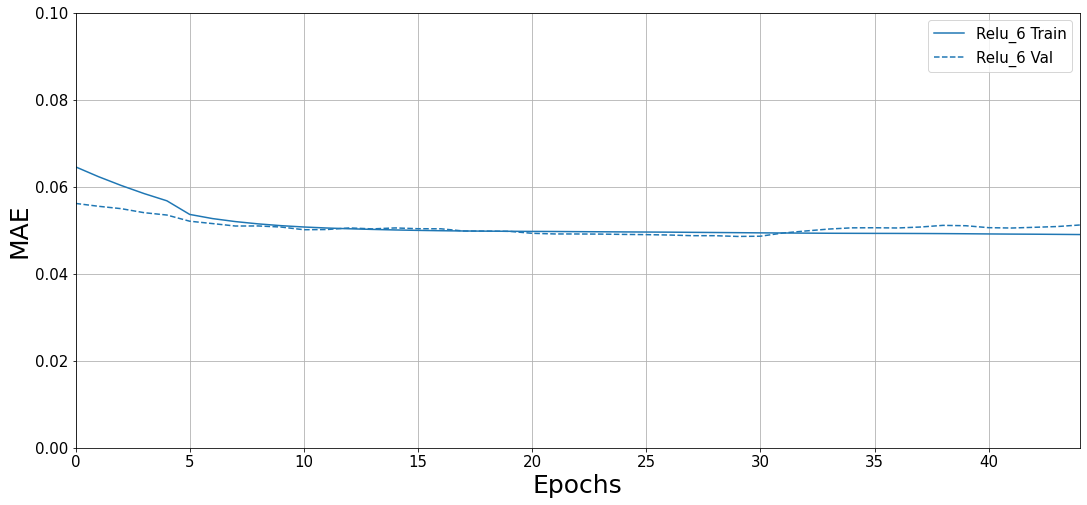

In [47]:
histories['ReLU_6'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.00, 0.1])
plt.ylabel('MAE')

In [48]:
nsize = 8
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0403,  mae:0.0791,  mse:0.0403,  val_loss:0.0275,  val_mae:0.0553,  val_mse:0.0275,  
........................................................................

Text(0, 0.5, 'MAE')

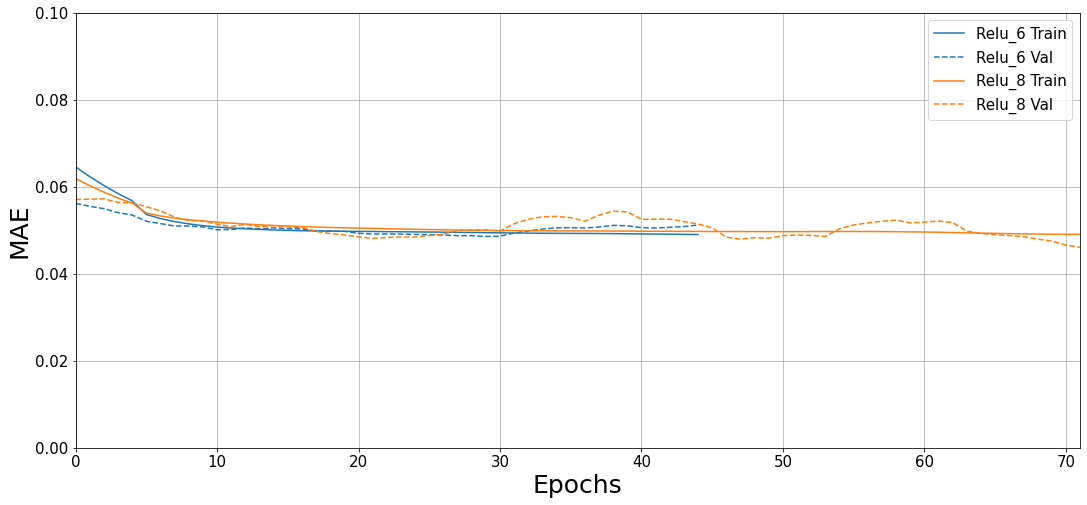

In [49]:
histories['ReLU_8'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.1])
plt.ylabel('MAE')

In [50]:
nsize = 16
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0315,  mae:0.0628,  mse:0.0315,  val_loss:0.0264,  val_mae:0.0471,  val_mse:0.0264,  
...................................................................................................

Text(0, 0.5, 'MAE')

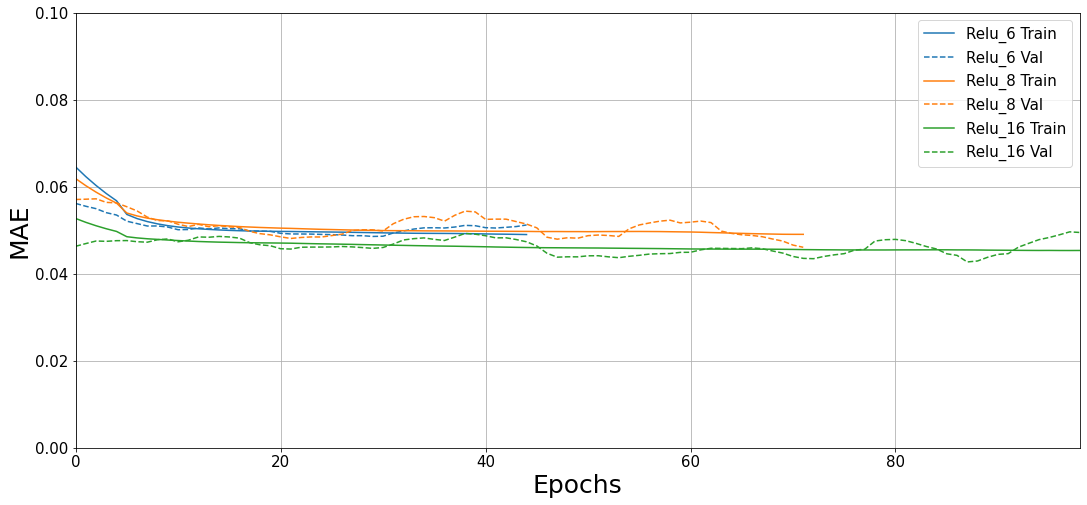

In [51]:
histories['ReLU_16'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.1])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

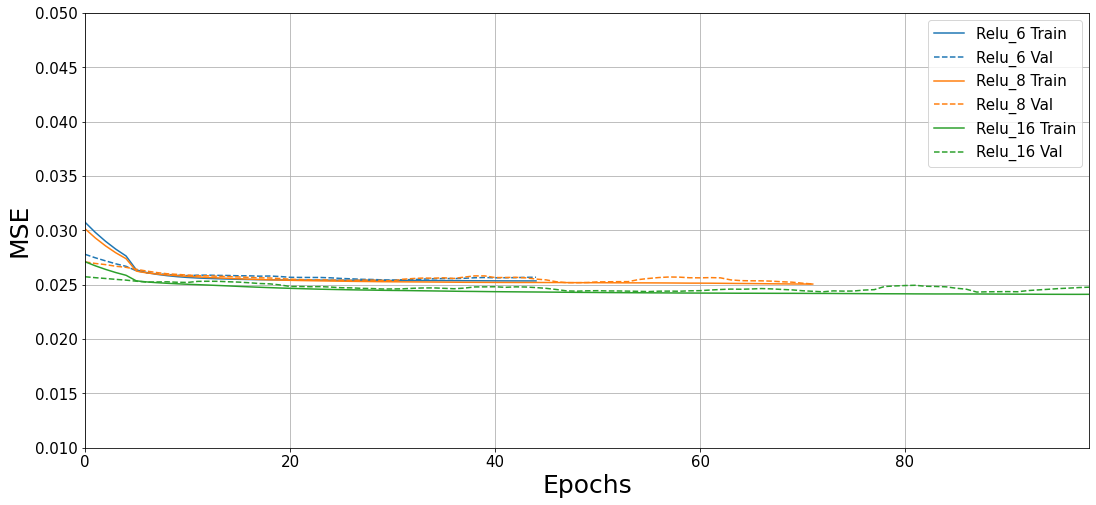

In [53]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.01, 0.05])
plt.ylabel('MSE')

In [54]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data2, normed_test_labels, verbose=1)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

99118/99118 [==============================] - 2s 24us/sample - loss: 0.0253 - mae: 0.0491 - mse: 0.0253
Testing set for model 1, Mean Abs Error:    0.04911


In [55]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

99118/99118 - 2s - loss: 0.0248 - mae: 0.0427 - mse: 0.0248
Testing set for model 2, Mean Abs Error:              0.04273


In [56]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

99118/99118 - 2s - loss: 0.0241 - mae: 0.0420 - mse: 0.0241
Testing set for model 3, Mean Abs Error:              0.04204


In [57]:
mae = [ mae1, mae2, mae3 ]
mae

[0.049114596, 0.042730827, 0.042039163]

In [58]:
mse = [ mse1, mse2, mse3 ]
mse

[0.025253206, 0.024751522, 0.024075357]

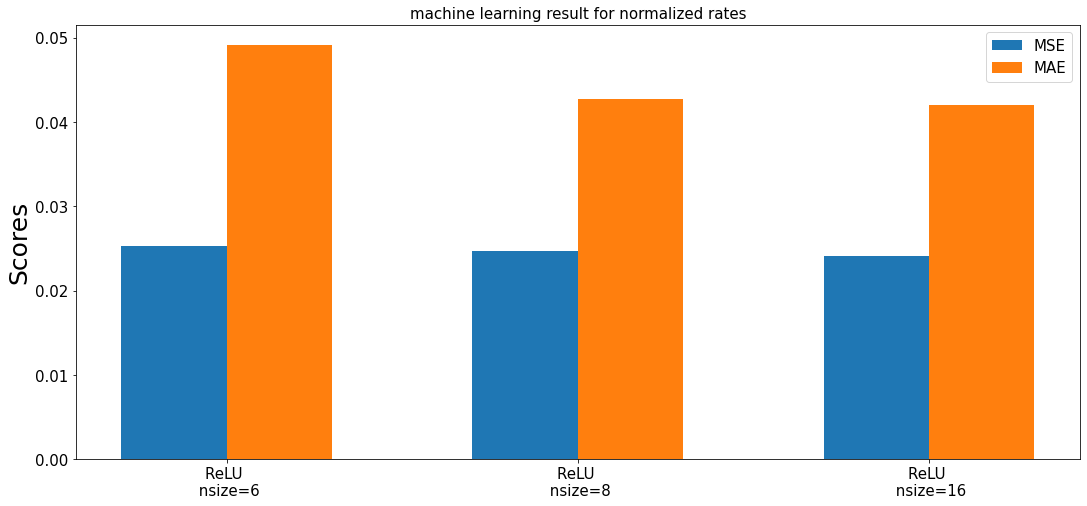

In [59]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'ReLU \n nsize=6',
 'ReLU \n nsize=8',
 'ReLU \n nsize=16',]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [60]:
test_true_mass  = np.exp(test_labels.pop('depo_mass'))

In [61]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [62]:
labels = [ "depo_mass" ]

p1 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=labels)

In [63]:
test_predict1 = backtransform(p1,train_labels_stats)

In [64]:
test_predict1.describe()

depo_mass
count  99118.000000
mean     -15.075404
std        2.032231
min      -26.862454
25%      -15.272902
50%      -14.539026
75%      -14.036166
max       -9.506236

In [65]:
test_predict1_mass  = np.exp(test_predict1['depo_mass'])

In [66]:
p2 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=labels)

test_predict2 = backtransform(p2,train_labels_stats)

test_predict2_mass = np.exp(test_predict2['depo_mass'])

In [67]:
p4 = pd.DataFrame(data=model3.predict(normed_test_data2), columns=labels)

test_predict4 = backtransform(p4,train_labels_stats)

test_predict4_mass = np.exp(test_predict4['depo_mass'])

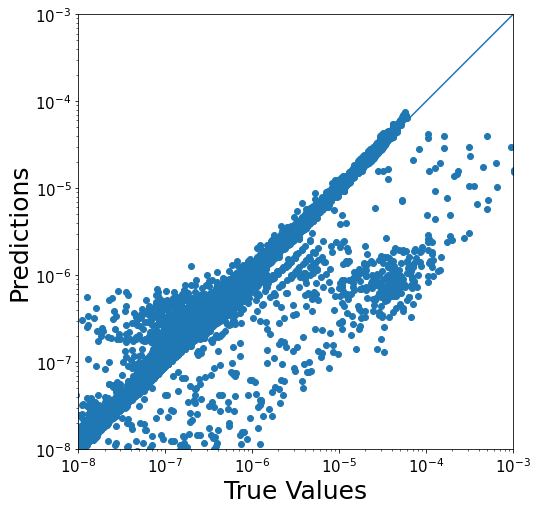

In [68]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-8, 1e-3
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

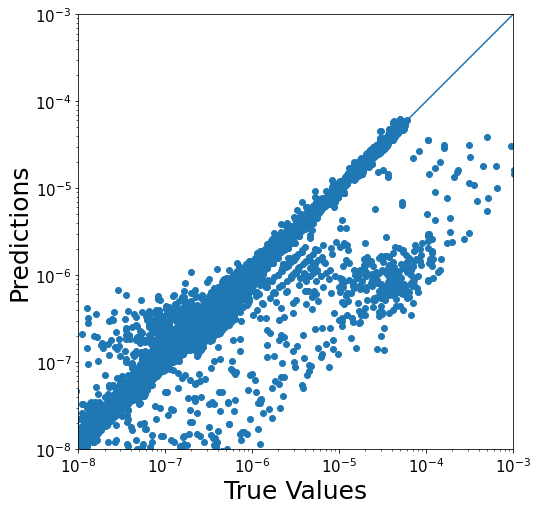

In [69]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict4_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [70]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'21'

In [71]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, labels_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["out_logtransform"] = xr.DataArray(labels_ltf, dims=("Nout_{}".format(nout)))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [72]:
labels   = 'depo_graupel_mass'
logtransformOutput = np.array([True], dtype=bool)

features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel, T, rho'
logtransformInput  = np.array([True, True, True, True, False, False], dtype=bool)

filename = 'saved_model_v2/depo_graupel_model1_'+version+'.nc'
save2netcdf(model1,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)

filename = 'saved_model_v2/depo_graupel_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)

filename = 'saved_model_v2/depo_graupel_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)


Saving model to saved_model_v2/depo_graupel_model1_21.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, T, rho
  Labels:     depo_graupel_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 6), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 6), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 1), Activation: linear
Saving model to saved_model_v2/depo_graupel_model2_21.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, T, rho
  Labels:     depo_graupel_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 1), Activation: linear
Saving model to saved_model_v2/depo_graupel_model3_21.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, T, rho
  Labels:  